# Final Evalaution of range data model

The model was chosen in 11, the data input in notebook 12, the causal vs non-causal design compared in notebook 13, regularization investigated in notebook 14 and the hyperparameters chosen from 15.

First the model is trained on subjects A, B, D, E, F. 80% of this data is used for training whilst the remaining 20% is used for validation which allows the use of erly stopping to prevent overfitting.

The model is then evaluated on the test subject C. Up until this point the model has not been exposed to this data.


From inspection of the dataset it was found that the last 14% of mesuremtns from each recording of subject F was corrpupted and contained only zero values. This notebook reruns the work conducted in notebook 16 but excludes subject F. This corrupt data is removed for this evaluation.

## Notebook setup

In [0]:
# Plot graphs inline
%matplotlib inline

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [1]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
    
DATA_PATH_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_applied/' # not used
DATA_PATH_NO_MTI = BASE_PATH + 'data/processed/range_FFT/3/MTI_not_applied/'

RESULTS_PATH = BASE_PATH + 'results/range_data_model_final_evaluation_without_corrupt/'
HYPERPARAMETER_PATH = BASE_PATH + 'results/range_data_model_hyperparameter_search/'

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
MODEL_PATH = BASE_PATH + 'models/range_data_model_final_evaluation/'
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

In [2]:
from keras import backend as K 
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
from keras.utils import Sequence, to_categorical
from keras.layers import Input, Conv1D, Multiply, Add, Activation, AveragePooling1D, Flatten, Dense
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.models import Model
from keras.callbacks import EarlyStopping
import sys

Using TensorFlow backend.


In [0]:
# needed for CheckpointSaver
# https://github.com/scikit-optimize/scikit-optimize/issues/678
! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
from skopt import load

  Cloning https://github.com/scikit-optimize/scikit-optimize/ to /tmp/pip-req-build-bowpey8q
  Stored in directory: /tmp/pip-ephem-wheel-cache-105qldf1/wheels/66/66/b5/e1160753c1f4d7763be2755539df2c2ebd6e50f987dbea6abf
Successfully built scikit-optimize


## Data Setup

In [0]:
# Load in data dictionary.
# This does not load in any actual data,
# just the dictionary with the names of the files and their associated labels
with open(DATA_PATH_NO_MTI + "index.pkl", "rb") as file:
    data = pickle.load(file)

In [0]:
def convert_label_to_int(label):
    if label == "walking":
        return 0
    if label == "pushing":
        return 1
    if label == "sitting":
        return 2
    if label == "pulling":
        return 3
    if label == "circling":
        return 4
    if label == "clapping":
        return 5
    if label == "bending":
        return 6

In [21]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)

In [0]:
# Remove corrupt data from F
# 570 files per 60s recording
# From investigating the files, final 14% is corrupted
# T0 be sure, remove final 20%
# 570 * 0.2 = 114
# slice :456
for target in target_names:
    for i in range(len(data['F'][target])):
        data['F'][target][i] = data['F'][target][i][:456]

In [0]:
data['F'][target][0]

['120_0.npy',
 '120_1.npy',
 '120_2.npy',
 '120_3.npy',
 '120_4.npy',
 '120_5.npy',
 '120_6.npy',
 '120_7.npy',
 '120_8.npy',
 '120_9.npy',
 '120_10.npy',
 '120_11.npy',
 '120_12.npy',
 '120_13.npy',
 '120_14.npy',
 '120_15.npy',
 '120_16.npy',
 '120_17.npy',
 '120_18.npy',
 '120_19.npy',
 '120_20.npy',
 '120_21.npy',
 '120_22.npy',
 '120_23.npy',
 '120_24.npy',
 '120_25.npy',
 '120_26.npy',
 '120_27.npy',
 '120_28.npy',
 '120_29.npy',
 '120_30.npy',
 '120_31.npy',
 '120_32.npy',
 '120_33.npy',
 '120_34.npy',
 '120_35.npy',
 '120_36.npy',
 '120_37.npy',
 '120_38.npy',
 '120_39.npy',
 '120_40.npy',
 '120_41.npy',
 '120_42.npy',
 '120_43.npy',
 '120_44.npy',
 '120_45.npy',
 '120_46.npy',
 '120_47.npy',
 '120_48.npy',
 '120_49.npy',
 '120_50.npy',
 '120_51.npy',
 '120_52.npy',
 '120_53.npy',
 '120_54.npy',
 '120_55.npy',
 '120_56.npy',
 '120_57.npy',
 '120_58.npy',
 '120_59.npy',
 '120_60.npy',
 '120_61.npy',
 '120_62.npy',
 '120_63.npy',
 '120_64.npy',
 '120_65.npy',
 '120_66.npy',
 '120

## DataGenerator

In [0]:
'''Based on code from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly'''

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, labels, batch_size=32, dim=(3000),
                 n_classes=7, shuffle=False, data_directory='data/',
                 bin_range=(0,60), take_average=False, every_second_cell=False):
        """Initialization"""
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_directory = data_directory
        self.bin_range=bin_range
        self.take_average = take_average
        self.every_second_cell = every_second_cell
        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.take_average:
                X[i,] = abs(np.average(np.load(self.data_directory + ID), axis=1)[:,np.newaxis])
                
            elif self.every_second_cell:
                X[i,] = abs(np.load(self.data_directory + ID))[:,::2]
                
            else:
                X[i,] = abs(np.load(self.data_directory + ID))[:,self.bin_range[0]:self.bin_range[1]]
                
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

## Model: Wavenet model adapted based on interpretation from Wavenet Paper

Keras implementation of wavenet model taken from https://github.com/basveeling/wavenet and https://github.com/mjpyeon/wavenet-classifier

This model has then been adapted to the classification task based on the intrustions from the paper "WAVENET: A GENERATIVE MODEL FOR RAW AUDIO" (https://arxiv.org/pdf/1609.03499.pdf)

Specifically:
"For this task we added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160× downsampling).  The pooling layer was followed by a few non-causal convolutions."

In [0]:
class WaveNetClassifier:
    def __init__(self, input_shape, output_shape, kernel_size=2, dilation_depth=9, nb_stacks=1, nb_filters=40,
                 pool_size=80, kernel_size_2=100, use_skip_connections=True, causal=True, residual_l2=0.001,
                 conv_l2=0.001, fully_l2=0.001, use_batch_norm=True, num_dense_nodes=512):

        self.activation = 'softmax'
        self.pool_size = pool_size
        self.kernel_size_2 = kernel_size_2 # kernel size for later conV 1d (not dilated)
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size # kernel size for dilated  layers
        self.dilation_depth = dilation_depth
        self.nb_filters = nb_filters
        self.residual_l2 = residual_l2 # l2 value for residual layers
        self.conv_l2 = conv_l2 # l2 value for stack of standard conv layers
        self.fully_l2 = fully_l2 # l2 value for fully connected layer
        self.use_skip_connections = use_skip_connections
        self.use_batch_norm = use_batch_norm
        self.num_dense_nodes = num_dense_nodes
        self.input_shape = input_shape
        self.output_shape = output_shape
        if causal:
            self.padding = 'causal'
        else:
            self.padding = 'same'

        if len(input_shape) == 1:
            self.expand_dims = True
        elif len(input_shape) == 2:
            self.expand_dims = False
        else:
            print('ERROR: wrong input shape')
            sys.exit()

        self.model = self.build_model()

    def residual_block(self, x, i, stack_nb):
        original_x = x
        tanh_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_tanh_s%d' % (2 ** i, stack_nb), activation='tanh',
                          kernel_regularizer=l2(self.residual_l2))(x)
        sigm_out = Conv1D(self.nb_filters, self.kernel_size, dilation_rate=2 ** i, padding=self.padding,
                          name='dilated_conv_%d_sigm_s%d' % (2 ** i, stack_nb), activation='sigmoid',
                          kernel_regularizer=l2(self.residual_l2))(x)
        x = Multiply(name='gated_activation_%d_s%d' % (i, stack_nb))([tanh_out, sigm_out])

        res_x = Conv1D(self.nb_filters, 1, padding='same', kernel_regularizer=l2(self.residual_l2))(x)
        skip_x = Conv1D(self.nb_filters, 1, padding='same', kernel_regularizer=l2(self.residual_l2))(x)
        res_x = Add()([original_x, res_x])
        return res_x, skip_x

    def build_model(self):
        input_layer = Input(shape=self.input_shape, name='input_part')
        out = input_layer
        skip_connections = []
        out = Conv1D(self.nb_filters, self.kernel_size,
                     dilation_rate=1,
                     padding=self.padding,
                     name='initial_causal_conv'
                     )(out)
        for stack_nb in range(self.nb_stacks):
            for i in range(0, self.dilation_depth + 1):
                out, skip_out = self.residual_block(out, i, stack_nb)
                skip_connections.append(skip_out)

        if self.use_skip_connections:
            out = Add()(skip_connections)
        out = Activation('relu')(out)
        # added a mean-pooling layer after the dilated convolutions that aggregated the activations to coarser frames
        # spanning 10 milliseconds (160× downsampling)
        # mean pooling layer adjust pool_size_1 to change downsampling
                
        out = AveragePooling1D(self.pool_size, padding='same', name='mean_pooling_layer_downsampling')(out)

        # few non-causal convolutions
        # In notebooks 11, 12 and 13 self.kernel_size_2 was incorrectly represented as pooling sizes.
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.nb_filters, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)
        
        if self.use_batch_norm:
            out = BatchNormalization()(out)
        
        out = Conv1D(self.output_shape, self.kernel_size_2, strides=2, padding='same', activation='relu',
                     kernel_regularizer=l2(self.conv_l2))(out)

        if self.use_batch_norm:
            out = BatchNormalization()(out)
            
        out = Flatten()(out)
        out = Dense(num_dense_nodes, activation='relu', kernel_regularizer=l2(self.fully_l2))(out)
        out = Dense(self.output_shape, activation='softmax')(out)

        return Model(input_layer, out)

    def get_model(self):
        return self.model

    def get_summary(self):
        self.model.summary()

    def get_receptive_field(self):
        k = self.kernel_size
        n = self.dilation_depth
        s = self.nb_stacks
        r_s = k + (2*(k-1)*((2**(n-1))-1))  # receptive field for one stack
        return (s*r_s) - (s-1)  # total receptive field for 's' number of stacks

# Experiment Setup

In [14]:
SAVE_RESULTS_TEST_C = False
SAVE_GRAPHS_TEST_C = True

SAVE_RESULTS_20 = False
SAVE_GRAPHS_20 = True

SAVE_RESULTS_6_FOLD = False
SAVE_GRAPHS_6_FOLD = True

## Load Hyperparameters

In [0]:
# needed for loading results (objective needs to be defined)
def objective():
    return 0

In [0]:
dimensions = ['n_filters', 'kernel_size', 'dilation_depth', 'number_of_stacks',
              'pool_size', 'kernel_size_2', 'early_stopping_patience']

# res_gp = load(HYPERPARAMETER_PATH + "res_gp_complete.pkl")
res_gp = load(HYPERPARAMETER_PATH + "res_gp_checkpoint.pkl")

parameters = res_gp.x

In [0]:
for index, parameter in enumerate(parameters):
    print(dimensions[index] + ":", parameter)

n_filters: 32
kernel_size: 3
dilation_depth: 3
number_of_stacks: 2
pool_size: 6
kernel_size_2: 2
early_stopping_patience: 4


In [0]:
n_filters = int(parameters[0])
kernel_size = int(parameters[1])
dilation_depth = int(parameters[2])
number_of_stacks = int(parameters[3])
pool_size = int(parameters[4])
kernel_size_2 = int(parameters[5])
early_stopping_patience = int(parameters[6])

## Set Params

In [0]:
bin_range = (0, 63)
data_shape = (3000, 32)

activation = 'softmax'

epochs = 10
batch_size = 16

num_dense_nodes = 512

residual_l2 = 0.001
conv_l2 = 0.001
fully_l2 = 0.001
use_batch_norm = False

# Parameters for data generators
data_gen_params = {'dim': data_shape,
                   'batch_size': batch_size,
                   'n_classes': nb_classes,
                   'data_directory': DATA_PATH_NO_MTI,
                   'bin_range': bin_range,
                   'every_second_cell': True}

## Create Classifier

In [0]:
wnc = WaveNetClassifier((data_shape), (nb_classes), kernel_size=kernel_size,
                        dilation_depth=dilation_depth, nb_stacks=number_of_stacks,
                        nb_filters=n_filters,
                        pool_size=pool_size, kernel_size_2=kernel_size_2,
                        residual_l2=residual_l2, conv_l2=conv_l2, fully_l2=fully_l2,
                        use_batch_norm=use_batch_norm)

# Evaluating on subject C

In [0]:
def split_train_val_test_by_subject(data, test_subject):
    labels = {}
    partition = {'train': [], 'validation': [], 'test': []}  # contains list of training and validation ID's

    for subject_letter, actions in data.items():
        for action, results in actions.items():
            for result in results:
                # do not split the test subject
                if subject_letter == test_subject:
                    for row in result:
                        partition["test"].append(row)
                        labels[row] = convert_label_to_int(action)
                        
                # if not test subject split data 80:20 (in consectutive chunks)
                else:            
                    res = np.array(result)
                    # Split into 5 folds then take 1 fold for 20%
                    split_actions = np.array_split(res, 5)
                    for fold in range(5):
                        data = split_actions[fold]
                        if fold == 0:
                            for row in data:
                                partition["validation"].append(row)
                                labels[row] = convert_label_to_int(action)

                        else:
                            for row in data:
                                partition["train"].append(row)
                                labels[row] = convert_label_to_int(action)       
                                
    return {"complete_index": labels, "partition":partition}

In [0]:
data_split = split_train_val_test_by_subject(data, "C")
complete_index = data_split["complete_index"]
partition = data_split["partition"]

### Train Model

In [0]:
wnc.build_model()
model = wnc.get_model()

training_generator = DataGenerator(partition['train'], complete_index, **data_gen_params, shuffle=True)
validation_generator = DataGenerator(partition['validation'], complete_index, **data_gen_params, shuffle=False)

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

callback_list = []
# -1 used to represent no early stopping
if early_stopping_patience != -1:
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)
    callback_list.append(early_stopping)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              callbacks=callback_list)

['loss', 'acc']


"\ncallback_list = []\n# -1 used to represent no early stopping\nif early_stopping_patience != -1:\n    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)\n    callback_list.append(early_stopping)\n\nhistory = model.fit_generator(generator=training_generator,\n                              validation_data=validation_generator,\n                              epochs=epochs,\n                              callbacks=callback_list)\n"

### Evaluate Model

In [0]:
test_generator = DataGenerator(partition['test'], complete_index, **data_gen_params, shuffle=False)

predictions = model.predict_generator(test_generator)
predictions = np.argmax(predictions,axis=1)
true_labels = []
for ID in test_generator.list_IDs:
    true_labels.append(complete_index[ID])

true_labels = np.array(true_labels)
true_labels = true_labels[:len(predictions)]

cm = confusion_matrix(true_labels, predictions)

evaluation = model.evaluate_generator(test_generator)

results = {
    "confusion_matrix": cm,
    "loss": evaluation[0],
    "accuracy": evaluation[1],
    "history": history.history
}

### Save Results

In [0]:
if SAVE_RESULTS_TEST_C:
    with open(RESULTS_PATH + "results_test_c.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Load Results

In [15]:
with open(RESULTS_PATH + "results_c.pkl", 'rb') as results_file:
    results = pickle.load(results_file)

### Visualize Results

In [0]:
results

{'accuracy': 0.7432228915662651,
 'confusion_matrix': array([[1138,    0,    0,    0,    2,    0,    0],
        [   0,  567,    4,    0,  174,    5,  390],
        [   7,   12, 1121,    0,    0,    0,    0],
        [   0,    0,   17,    6, 1028,    4,   85],
        [   0,    0,    0,    0, 1140,    0,    0],
        [   1,    0,    0,    0,  304,  822,   13],
        [   0,    0,    0,    0,    0,    0, 1128]]),
 'history': {'acc': [0.7236879232505643,
   0.9562641083521445,
   0.9735468397291196,
   0.978096783295711,
   0.9874082957110609,
   0.9848335214446953,
   0.9866676072234764,
   0.9933338036117382,
   0.9862443566591422,
   0.9896303611738149],
  'loss': [1.2851749686671434,
   0.5325409241575689,
   0.37371869874659835,
   0.30041091665457387,
   0.23029342508174766,
   0.2108712672901342,
   0.18187170054839238,
   0.14703324038543766,
   0.15380835301467716,
   0.1466344990273496],
  'val_acc': [0.8964446952595937,
   0.9549943566591422,
   0.9497742663656885,
   0.943

In [0]:
K.clear_session()

In [16]:
print("Accuracy:",results["accuracy"]*100)

Accuracy: 74.32228915662651


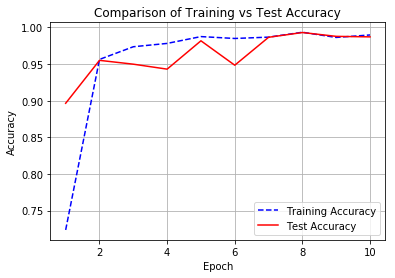

In [18]:
training_acc = results["history"]['acc']
test_acc = results["history"]['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'b--')
plt.plot(epoch_count, test_acc, 'r-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison of Training vs Test Accuracy")
plt.grid()
if SAVE_GRAPHS_TEST_C:
    plt.savefig(RESULTS_PATH + "training_vs_test_acc.pdf", format='pdf')
plt.show()

In [19]:
def plot_confusion_matrix(cm, classes, save=False, path='/'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save:
        plt.savefig(path, format='pdf')
    plt.show()

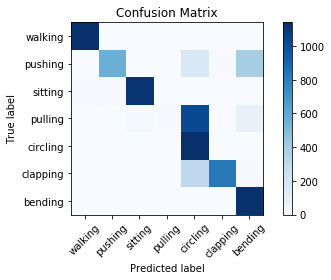

In [22]:
plot_confusion_matrix(results["confusion_matrix"], target_names)

# Evaluating on subset of the data (all subjects) 5-Fold
use 60% for training, 20% for validation (early stopping) and the final 20% for testing.

In [0]:
def split_data_by_fold(data, test_fold, validation_fold, total_folds=5):
    labels = {}
    partition = {'train':[], 'validation':[], 'test':[]}

    for user_letter, actions in data.items():
        for action, results in actions.items():
            for result in results:
                res = np.array(result)
                # Split into 5 folds then take 1 fold for 20%
                split_actions = np.array_split(res, 5)
                for fold in range(total_folds):
                    data = split_actions[fold]
                    if fold == test_fold:
                        for row in data:
                            partition["test"].append(row)
                            labels[row] = convert_label_to_int(action)
                            
                    elif fold == validation_fold:
                        for row in data:
                            partition["validation"].append(row)
                            labels[row] = convert_label_to_int(action)

                    else:
                        for row in data:
                            partition["train"].append(row)
                            labels[row] = convert_label_to_int(action) 
                            
    return {"complete_index": labels, "partition":partition}

In [26]:
k_fold_results = {}
number_of_folds = 5
for fold in range(number_of_folds):
    k_fold_results[str(fold)] = {}

In [0]:
average_accuracy = 0
average_loss = 0
for fold in range(number_of_folds):
    test_fold = fold
    validation_fold = (test_fold + 1) % number_of_folds
    print("Fold:", fold)
    
    data_split = split_data_by_fold(data, test_fold, validation_fold, number_of_folds)
    complete_index = data_split["complete_index"]
    partition = data_split["partition"]
    
    wnc.build_model()
    model = wnc.get_model()

    training_generator = DataGenerator(partition['train'], complete_index, **data_gen_params, shuffle=True)
    validation_generator = DataGenerator(partition['validation'], complete_index, **data_gen_params, shuffle=False)
    test_generator = DataGenerator(partition['test'], complete_index, **data_gen_params, shuffle=False)

    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callback_list = []
    # -1 used to represent no early stopping
    if early_stopping_patience != -1:
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)
        callback_list.append(early_stopping)

    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        callbacks=callback_list)

    evaluation = model.evaluate_generator(test_generator)
    loss = evaluation[0]
    accuracy = evaluation[1]

    average_accuracy += accuracy
    average_loss += loss
    k_fold_results[str(fold)]["accuracy"] = accuracy
    k_fold_results[str(fold)]["loss"] = loss
    
k_fold_results["average_accuracy"] = average_accuracy/number_of_folds
k_fold_results["average_loss"] = average_loss/number_of_folds

## Save Results

In [0]:
if SAVE_RESULTS_20:
    with open(RESULTS_PATH + "results_test_20.pkl", 'wb') as results_file:
        pickle.dump(k_fold_results, results_file)

## Load Results

In [27]:
with open(RESULTS_PATH + "results_20.pkl", 'rb') as results_file:
    k_fold_results = pickle.load(results_file)

## Visualize Results

In [24]:
print("Average Accuracy:", k_fold_results["average_accuracy"]*100)
print("Average Loss:", k_fold_results["average_loss"])

Average Accuracy: 97.94383226981441
Average Loss: 0.17315185022966728


In [5]:
k_fold_results

{'0': {'accuracy': 0.9721454880294659, 'loss': 0.2543782086058436},
 '1': {'accuracy': 0.9788976014760148, 'loss': 0.17906779756020355},
 '2': {'accuracy': 0.9890452029520295, 'loss': 0.13335545130101517},
 '3': {'accuracy': 0.978090405904059, 'loss': 0.12572393371170298},
 '4': {'accuracy': 0.9790129151291513, 'loss': 0.17323385996957108},
 'average_accuracy': 0.9794383226981441,
 'average_loss': 0.17315185022966728}

### Accuracy Fold Distribution

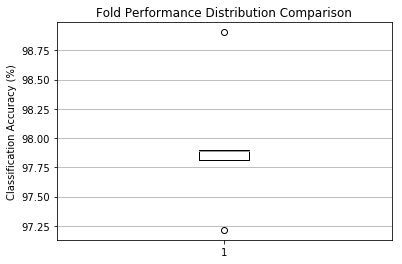

In [28]:
accuracies = []
for fold in range(number_of_folds):
    accuracies.append(k_fold_results[str(fold)]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
# plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_20:
     plt.savefig(RESULTS_PATH + "boxplot_20.pdf", format='pdf')

In [0]:
K.clear_session()

# Six-Fold Cross-Validation
One fold for each subject

In [29]:
subjects = ["A", "B", "C", "D", "E", "F"]

In [0]:
results_six_fold = {}
for subject in subjects:
    results_six_fold[subject] = {}

In [0]:
average_accuracy = 0
average_loss = 0
for subject in subjects:
    data_split = split_train_val_test_by_subject(data, subject)
    complete_index = data_split["complete_index"]
    partition = data_split["partition"]
    
    wnc.build_model()
    model = wnc.get_model()

    training_generator = DataGenerator(partition['train'], complete_index, **data_gen_params, shuffle=True)
    validation_generator = DataGenerator(partition['validation'], complete_index, **data_gen_params, shuffle=False)
    test_generator = DataGenerator(partition['test'], complete_index, **data_gen_params, shuffle=False)

    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callback_list = []
    # -1 used to represent no early stopping
    if early_stopping_patience != -1:
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)
        callback_list.append(early_stopping)

    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        callbacks=callback_list)

    evaluation = model.evaluate_generator(test_generator)
    loss = evaluation[0]
    accuracy = evaluation[1]
        
    average_accuracy += accuracy
    average_loss += loss
    results_six_fold[subject]["accuracy"] = accuracy
    results_six_fold[subject]["loss"] = loss

results_six_fold["avg_loss"] = average_loss/len(subjects)
results_six_fold["avg_acc"] = average_accuracy/len(subjects)
print("Average Loss:", average_loss/len(subjects))
print("Average Accuracy:", average_accuracy/len(subjects))

## Save Results

In [0]:
if SAVE_RESULTS_6_FOLD:
    with open(RESULTS_PATH + "results_6_fold.pkl", 'wb') as results_file:
        pickle.dump(results_six_fold, results_file)

## Load Results

In [30]:
with open(RESULTS_PATH + "results_6_fold.pkl", 'rb') as results_file:
    results_six_fold = pickle.load(results_file)

## Visualize Results

In [31]:
print("Average Accuracy:", results_six_fold["avg_acc"]*100)
print("Average Loss:", results_six_fold["avg_loss"])

Average Accuracy: 56.23100976116243
Average Loss: 3.9531040180912265


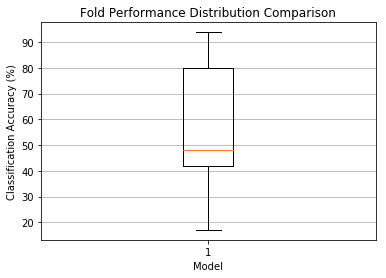

In [32]:
accuracies = []
for subject in subjects:
    accuracies.append(results_six_fold[subject]["accuracy"]*100)

plt.boxplot(accuracies, zorder=3)
plt.title("Fold Performance Distribution Comparison")
plt.xlabel("Model")
plt.ylabel("Classification Accuracy (%)")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
     plt.savefig(RESULTS_PATH + "boxplot_6_fold.pdf", format='pdf')

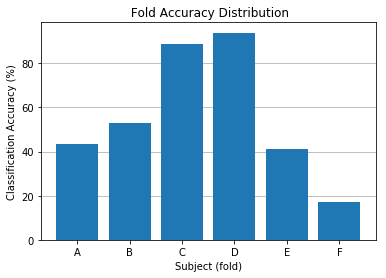

In [33]:
plt.bar(range(len(subjects)), accuracies, zorder=3)
plt.xticks(range(len(subjects)), subjects)
plt.xlabel("Subject (fold)")
plt.ylabel("Classification Accuracy (%)")
plt.title(" Fold Accuracy Distribution")
plt.grid(axis='y', zorder=0)
if SAVE_GRAPHS_6_FOLD:
    plt.savefig(RESULTS_PATH + "fold_accuracy_distribution_6_fold.pdf", format='pdf')
plt.show()